Correlation matrix (rounded):
      A2    B1    B3    C1    C2    C3    D1    D2    D3    E1    E2    E3  \
A2  1.00  0.03  0.55 -0.12  0.83  0.21  0.21  1.00  0.12  0.12  0.55 -0.12   
B1  0.03  1.00  0.54  0.46 -0.32 -0.48 -0.48  0.03  0.28  0.28  0.06 -0.65   
B3  0.55  0.54  1.00 -0.22  0.00 -0.38 -0.38  0.55  0.22  0.22  0.62 -0.22   
C1 -0.12  0.46 -0.22  1.00  0.00 -0.00 -0.00 -0.12  0.33  0.33 -0.51 -0.33   
C2  0.83 -0.32  0.00  0.00  1.00  0.50  0.50  0.83  0.00  0.00  0.25  0.00   
C3  0.21 -0.48 -0.38 -0.00  0.50  1.00  1.00  0.21  0.58  0.58  0.13  0.58   
D1  0.21 -0.48 -0.38 -0.00  0.50  1.00  1.00  0.21  0.58  0.58  0.13  0.58   
D2  1.00  0.03  0.55 -0.12  0.83  0.21  0.21  1.00  0.12  0.12  0.55 -0.12   
D3  0.12  0.28  0.22  0.33  0.00  0.58  0.58  0.12  1.00  1.00  0.22  0.33   
E1  0.12  0.28  0.22  0.33  0.00  0.58  0.58  0.12  1.00  1.00  0.22  0.33   
E2  0.55  0.06  0.62 -0.51  0.25  0.13  0.13  0.55  0.22  0.22  1.00  0.36   
E3 -0.12 -0.65 -0.22 -0.33  0.00  

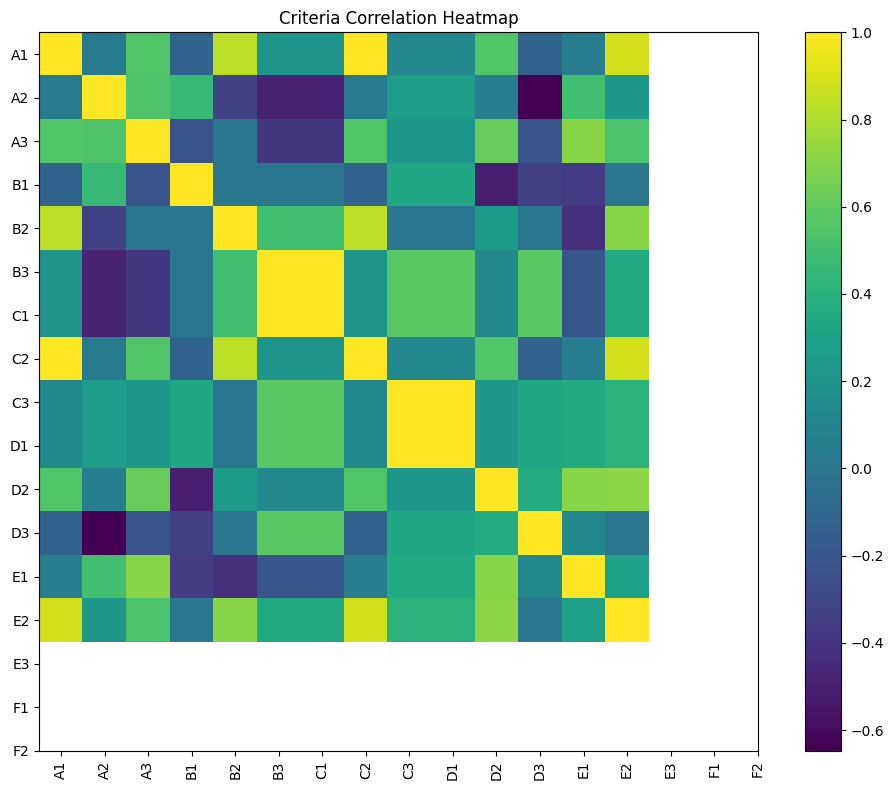

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

INPUT_CSV = "all_reports_bands.csv"

def main():
    # Load data
    df = pd.read_csv(INPUT_CSV, index_col="model")
    # Only keep criteria columns (A1..F2)
    criteria_cols = [c for c in df.columns if c[0] in "ABCDEF"]
    df_crit = df[criteria_cols]

    # Compute correlation matrix
    df_crit = df_crit.loc[:, df_crit.std() != 0] 
    corr = df_crit.corr(method="pearson")

    print("Correlation matrix (rounded):")
    print(corr.round(2))

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(corr.values, interpolation="nearest")
    ax.set_xticks(range(len(criteria_cols)))
    ax.set_yticks(range(len(criteria_cols)))
    ax.set_xticklabels(criteria_cols, rotation=90)
    ax.set_yticklabels(criteria_cols)
    fig.colorbar(cax, ax=ax)
    ax.set_title("Criteria Correlation Heatmap")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Plotting profile for report(edcafe)...


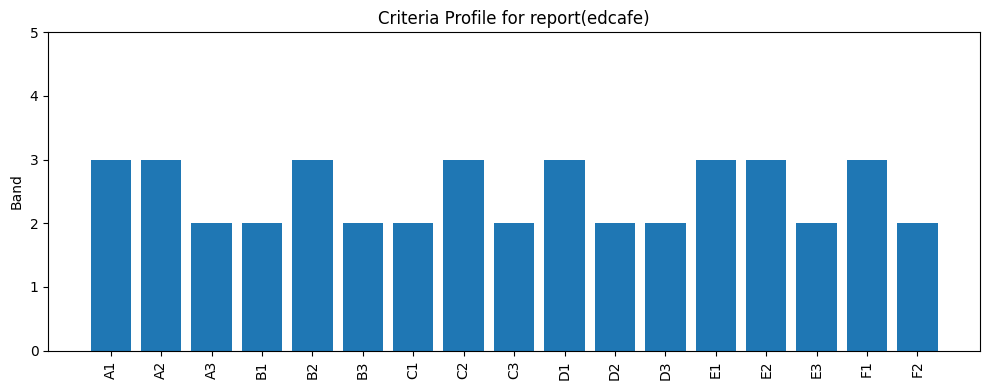

Plotting profile for report(radius)...


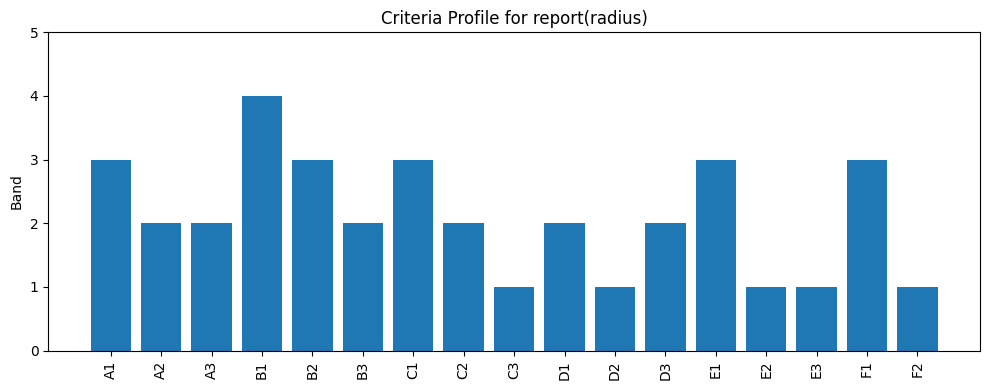

Plotting profile for report(eduaide)...


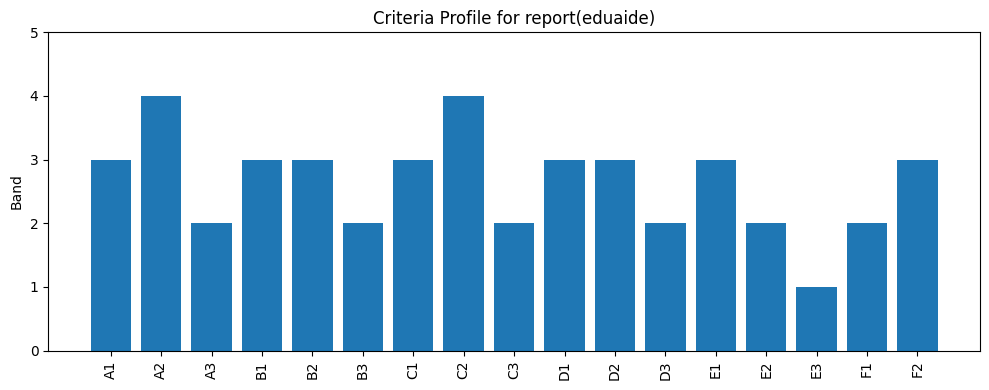

Plotting profile for report(slidesgo)...


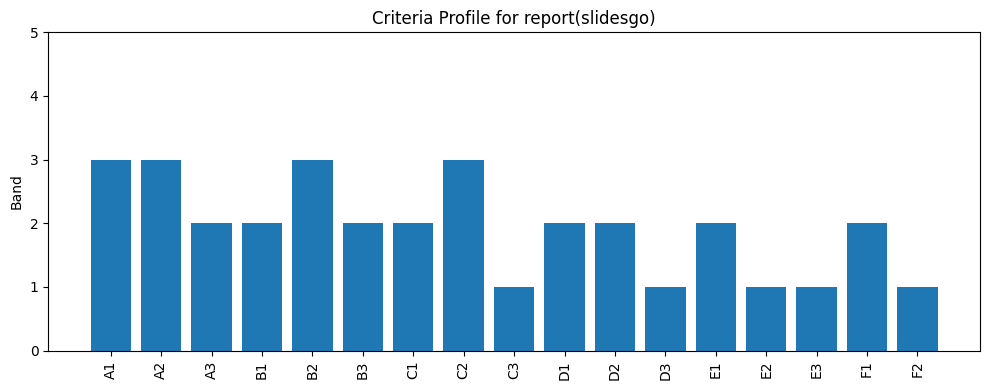

Plotting profile for report(brisk)...


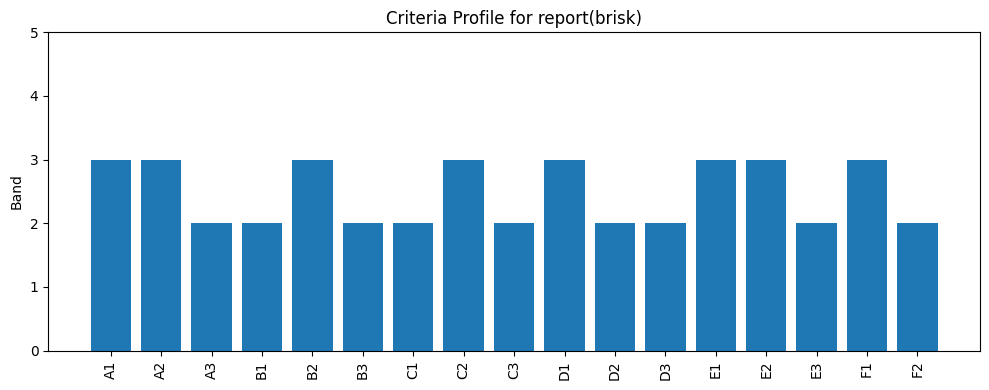

Plotting profile for report(GPT-5)...


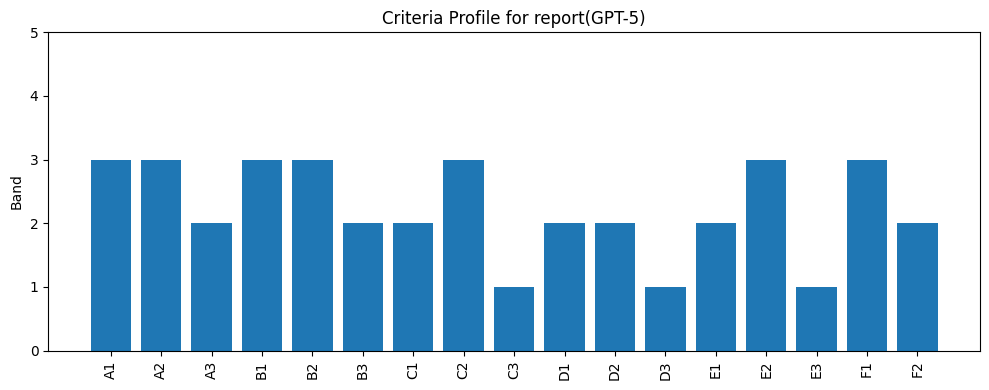

Plotting profile for report(khamingo)...


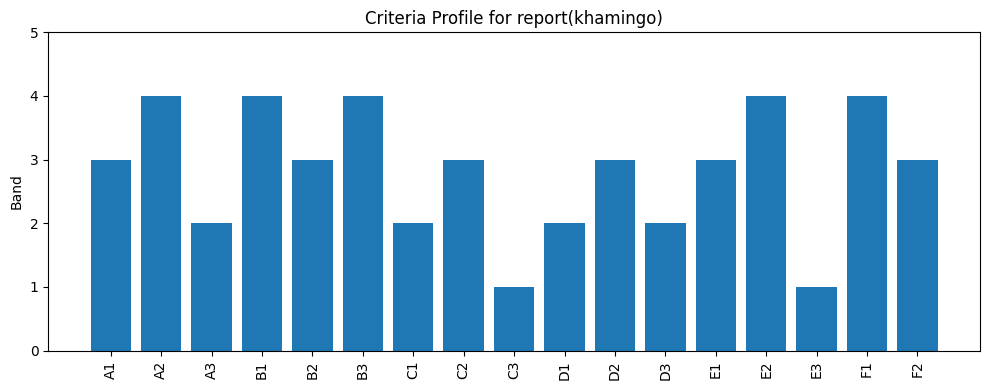

Plotting profile for report(autoclassmate)...


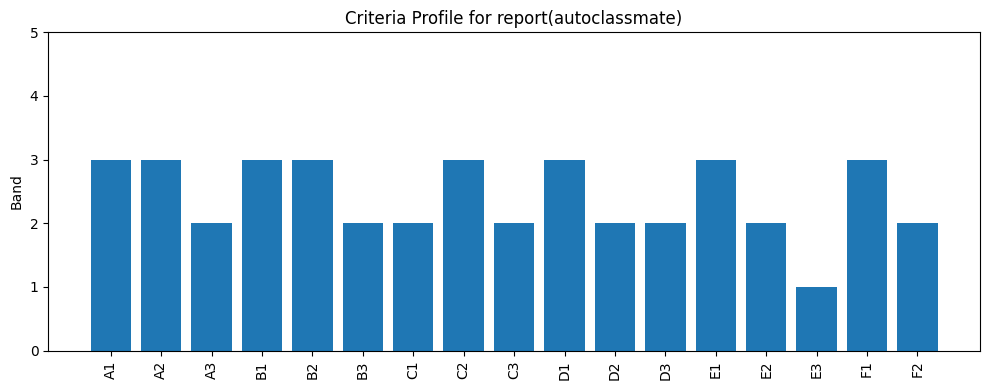

In [2]:
# 07_visualize_profiles.py
import pandas as pd
import matplotlib.pyplot as plt

INPUT_CSV = "all_reports_bands.csv"

def plot_model_profile(model_name: str, row, criteria_cols):
    fig, ax = plt.subplots(figsize=(10, 4))
    values = row[criteria_cols].values
    ax.bar(range(len(criteria_cols)), values)
    ax.set_xticks(range(len(criteria_cols)))
    ax.set_xticklabels(criteria_cols, rotation=90)
    ax.set_ylim(0, 5)  # bands are 1-4, so 0-5 gives headroom
    ax.set_ylabel("Band")
    ax.set_title(f"Criteria Profile for {model_name}")
    plt.tight_layout()
    plt.show()

def main():
    df = pd.read_csv(INPUT_CSV, index_col="model")
    criteria_cols = [c for c in df.columns if c[0] in "ABCDEF"]

    for model_name, row in df.iterrows():
        print(f"Plotting profile for {model_name}...")
        plot_model_profile(model_name, row, criteria_cols)

if __name__ == "__main__":
    main()

In [3]:
# 08_discover_guardrails.py
import pandas as pd
from itertools import product

INPUT_CSV = "all_reports_bands.csv"

def find_guardrail_candidates(df: pd.DataFrame,
                              max_band: int = 4,
                              min_support: int = 2):
    """
    Search for simple guardrail-like patterns:
    For criteria X, Y and thresholds t, u:
        If X <= t  =>  Y <= u
    that hold for all rows where X <= t.

    Parameters:
        df: DataFrame with criteria as columns
        max_band: maximum band value (e.g., 4)
        min_support: minimum number of rows where X <= t needed to consider a rule
    """
    criteria = [c for c in df.columns if c[0] in "ABCDEF"]
    rules = []

    for X, Y in product(criteria, repeat=2):
        if X == Y:
            continue

        # thresholds for antecedent and consequent
        for t in range(1, max_band + 1):      # X <= t
            mask = df[X] <= t
            support = mask.sum()

            # need at least some examples where X <= t
            if support < min_support:
                continue

            subset = df[mask]

            # now search for u such that Y <= u always holds in subset
            for u in range(1, max_band + 1):
                if (subset[Y] <= u).all():
                    # we found a rule: whenever X<=t, Y is never above u
                    rules.append({
                        "X": X,
                        "t": t,
                        "Y": Y,
                        "u": u,
                        "support": support
                    })
                    # we can break on first (smallest) u, since bigger u is weaker
                    break

    return rules

def main():
    df = pd.read_csv(INPUT_CSV, index_col="model")
    criteria_cols = [c for c in df.columns if c[0] in "ABCDEF"]
    df_crit = df[criteria_cols]

    rules = find_guardrail_candidates(df_crit, max_band=4, min_support=2)

    # Sort rules to show the strongest / strictest first
    # Heuristic: larger support, smaller t (more severe low) and smaller u (stricter cap)
    rules_sorted = sorted(
        rules,
        key=lambda r: (-r["support"], r["t"], r["u"], r["X"], r["Y"])
    )

    print("=== Candidate guardrail-like rules (data-driven) ===")
    for r in rules_sorted:
        print(
            f"If {r['X']} <= {r['t']} (support={r['support']} rows) "
            f"then {r['Y']} <= {r['u']} (always, in this dataset)."
        )

if __name__ == "__main__":
    main()

=== Candidate guardrail-like rules (data-driven) ===
If A3 <= 2 (support=8 rows) then C3 <= 2 (always, in this dataset).
If A3 <= 2 (support=8 rows) then D3 <= 2 (always, in this dataset).
If A3 <= 2 (support=8 rows) then E3 <= 2 (always, in this dataset).
If C3 <= 2 (support=8 rows) then A3 <= 2 (always, in this dataset).
If C3 <= 2 (support=8 rows) then D3 <= 2 (always, in this dataset).
If C3 <= 2 (support=8 rows) then E3 <= 2 (always, in this dataset).
If D3 <= 2 (support=8 rows) then A3 <= 2 (always, in this dataset).
If D3 <= 2 (support=8 rows) then C3 <= 2 (always, in this dataset).
If D3 <= 2 (support=8 rows) then E3 <= 2 (always, in this dataset).
If E3 <= 2 (support=8 rows) then A3 <= 2 (always, in this dataset).
If E3 <= 2 (support=8 rows) then C3 <= 2 (always, in this dataset).
If E3 <= 2 (support=8 rows) then D3 <= 2 (always, in this dataset).
If A3 <= 2 (support=8 rows) then A1 <= 3 (always, in this dataset).
If A3 <= 2 (support=8 rows) then B2 <= 3 (always, in this datas

NOW THE ONES EVALUATED BY ANA ON HER RUBRIC SYSTEM

Correlation matrix (rounded):
      A     B     C     D     F
A  1.00  0.87  1.00  0.50  1.00
B  0.87  1.00  0.87  0.87  0.87
C  1.00  0.87  1.00  0.50  1.00
D  0.50  0.87  0.50  1.00  0.50
F  1.00  0.87  1.00  0.50  1.00


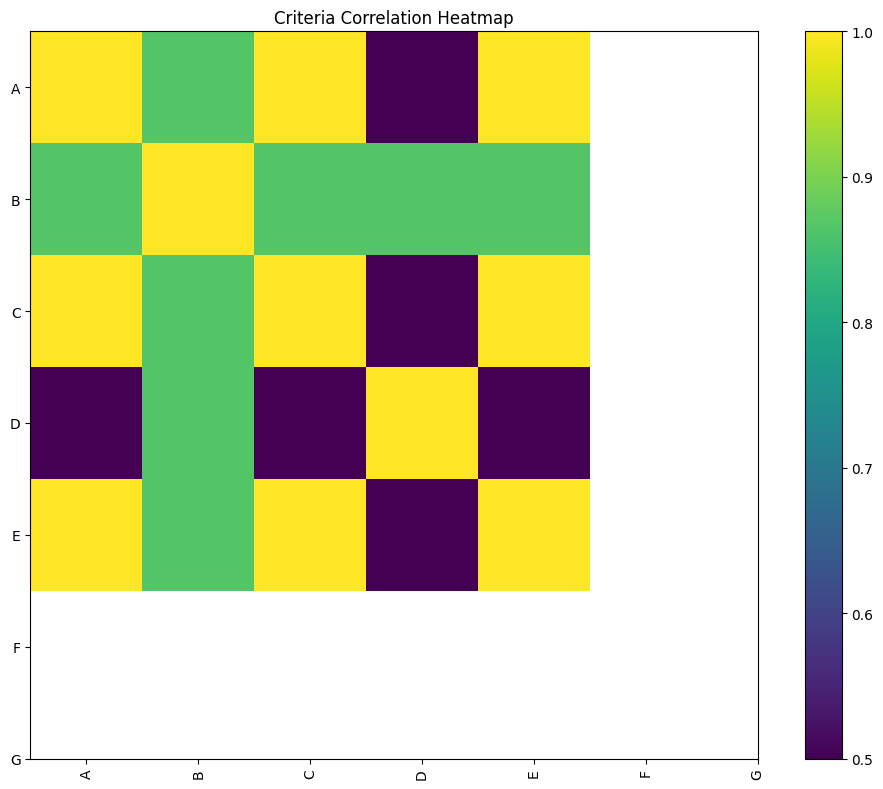

In [4]:
# 06_visualize_correlations.py
import pandas as pd
import matplotlib.pyplot as plt

INPUT_CSV = "rubric_converted.csv"

def main():
    # Load data
    df = pd.read_csv(INPUT_CSV, index_col="model")
    # Only keep criteria columns (A1..F2)
    criteria_cols = [c for c in df.columns if c[0] in "ABCDEFG"]
    df_crit = df[criteria_cols]

    # Compute correlation matrix
    df_crit = df_crit.loc[:, df_crit.std() != 0] 
    corr = df_crit.corr(method="pearson")

    print("Correlation matrix (rounded):")
    print(corr.round(2))

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(corr.values, interpolation="nearest")
    ax.set_xticks(range(len(criteria_cols)))
    ax.set_yticks(range(len(criteria_cols)))
    ax.set_xticklabels(criteria_cols, rotation=90)
    ax.set_yticklabels(criteria_cols)
    fig.colorbar(cax, ax=ax)
    ax.set_title("Criteria Correlation Heatmap")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Plotting profile for khanmigo...


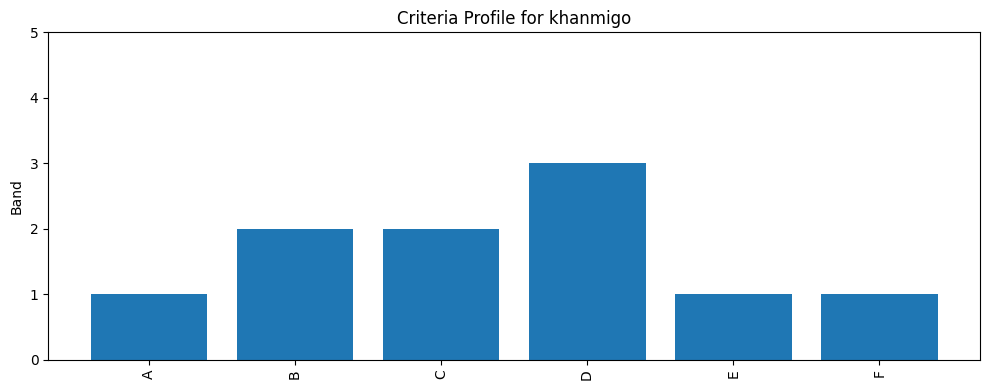

Plotting profile for gpt-5...


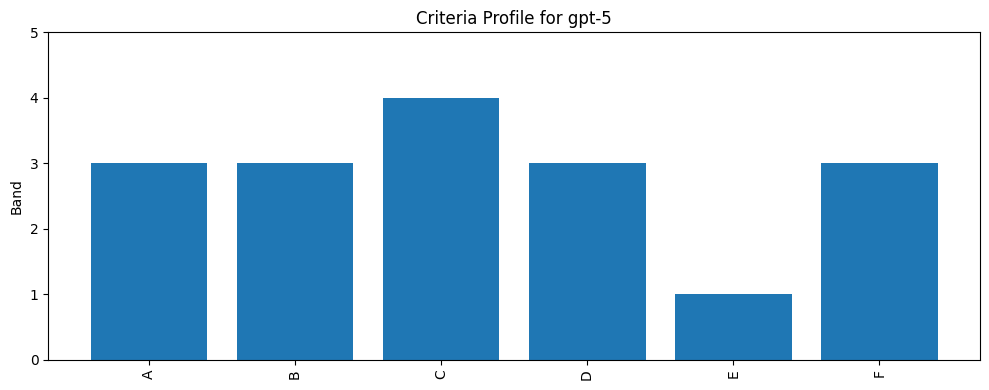

Plotting profile for eduaide...


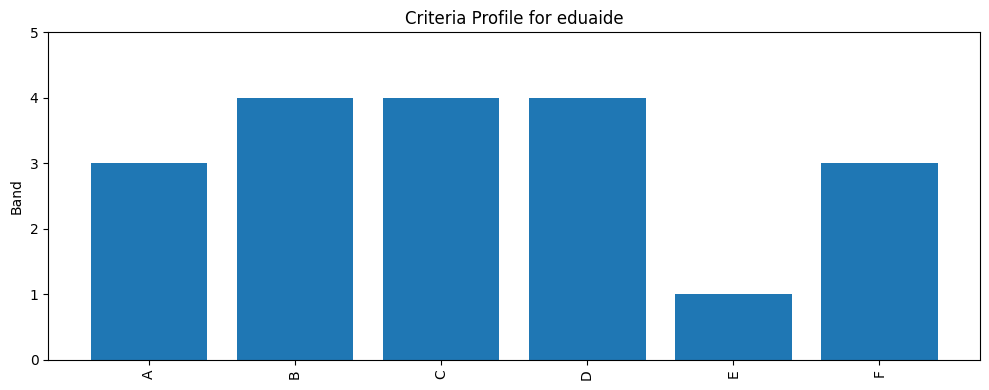

In [5]:
# 07_visualize_profiles.py
import pandas as pd
import matplotlib.pyplot as plt

INPUT_CSV = "rubric_converted.csv"

def plot_model_profile(model_name: str, row, criteria_cols):
    fig, ax = plt.subplots(figsize=(10, 4))
    values = row[criteria_cols].values
    ax.bar(range(len(criteria_cols)), values)
    ax.set_xticks(range(len(criteria_cols)))
    ax.set_xticklabels(criteria_cols, rotation=90)
    ax.set_ylim(0, 5)  # bands are 1-4, so 0-5 gives headroom
    ax.set_ylabel("Band")
    ax.set_title(f"Criteria Profile for {model_name}")
    plt.tight_layout()
    plt.show()

def main():
    df = pd.read_csv(INPUT_CSV, index_col="model")
    criteria_cols = [c for c in df.columns if c[0] in "ABCDEF"]

    for model_name, row in df.iterrows():
        print(f"Plotting profile for {model_name}...")
        plot_model_profile(model_name, row, criteria_cols)

if __name__ == "__main__":
    main()

In [6]:
# 08_discover_guardrails.py
import pandas as pd
from itertools import product

INPUT_CSV = "rubric_converted.csv"

def find_guardrail_candidates(df: pd.DataFrame,
                              max_band: int = 4,
                              min_support: int = 2):
    """
    Search for simple guardrail-like patterns:
    For criteria X, Y and thresholds t, u:
        If X <= t  =>  Y <= u
    that hold for all rows where X <= t.

    Parameters:
        df: DataFrame with criteria as columns
        max_band: maximum band value (e.g., 4)
        min_support: minimum number of rows where X <= t needed to consider a rule
    """
    criteria = [c for c in df.columns if c[0] in "ABCDEF"]
    rules = []

    for X, Y in product(criteria, repeat=2):
        if X == Y:
            continue

        # thresholds for antecedent and consequent
        for t in range(1, max_band + 1):      # X <= t
            mask = df[X] <= t
            support = mask.sum()

            # need at least some examples where X <= t
            if support < min_support:
                continue

            subset = df[mask]

            # now search for u such that Y <= u always holds in subset
            for u in range(1, max_band + 1):
                if (subset[Y] <= u).all():
                    # we found a rule: whenever X<=t, Y is never above u
                    rules.append({
                        "X": X,
                        "t": t,
                        "Y": Y,
                        "u": u,
                        "support": support
                    })
                    # we can break on first (smallest) u, since bigger u is weaker
                    break

    return rules

def main():
    df = pd.read_csv(INPUT_CSV, index_col="model")
    criteria_cols = [c for c in df.columns if c[0] in "ABCDEF"]
    df_crit = df[criteria_cols]

    rules = find_guardrail_candidates(df_crit, max_band=4, min_support=2)

    # Sort rules to show the strongest / strictest first
    # Heuristic: larger support, smaller t (more severe low) and smaller u (stricter cap)
    rules_sorted = sorted(
        rules,
        key=lambda r: (-r["support"], r["t"], r["u"], r["X"], r["Y"])
    )

    print("=== Candidate guardrail-like rules (data-driven) ===")
    for r in rules_sorted:
        print(
            f"If {r['X']} <= {r['t']} (support={r['support']} rows) "
            f"then {r['Y']} <= {r['u']} (always, in this dataset)."
        )

if __name__ == "__main__":
    main()

=== Candidate guardrail-like rules (data-driven) ===
If E <= 1 (support=3 rows) then A <= 3 (always, in this dataset).
If E <= 1 (support=3 rows) then F <= 3 (always, in this dataset).
If E <= 1 (support=3 rows) then B <= 4 (always, in this dataset).
If E <= 1 (support=3 rows) then C <= 4 (always, in this dataset).
If E <= 1 (support=3 rows) then D <= 4 (always, in this dataset).
If E <= 2 (support=3 rows) then A <= 3 (always, in this dataset).
If E <= 2 (support=3 rows) then F <= 3 (always, in this dataset).
If E <= 2 (support=3 rows) then B <= 4 (always, in this dataset).
If E <= 2 (support=3 rows) then C <= 4 (always, in this dataset).
If E <= 2 (support=3 rows) then D <= 4 (always, in this dataset).
If A <= 3 (support=3 rows) then E <= 1 (always, in this dataset).
If F <= 3 (support=3 rows) then E <= 1 (always, in this dataset).
If A <= 3 (support=3 rows) then F <= 3 (always, in this dataset).
If E <= 3 (support=3 rows) then A <= 3 (always, in this dataset).
If E <= 3 (support=3 ro